# Autoencoder
This model using one of autoencoder abilities that allow to compare input and output. Based on that, autoencoder could determine if sample is normal or anomalous.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split

## Data preparation

In [2]:
dataframe = pd.read_csv('../dataset/ecg.csv', header=None)
raw_data = dataframe.values

labels = raw_data[:, -1]
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=50)


train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

## Set models parameters

In [3]:
latent_dim = 64
input_dim = 140

## Define encoder model

In [4]:
def build_encoder():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(latent_dim, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(input_dim, activation='relu'))
    return model

## Define decoder model

In [5]:
def build_decoder():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(input_dim, activation='sigmoid'))
    return model

## Define autoencoder

In [6]:
def build_autoencoder():
    encoder = build_encoder()
    decoder = build_decoder()

    encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5), loss=tf.keras.losses.binary_crossentropy)
    decoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5), loss=tf.keras.losses.binary_crossentropy)

    encoder_input = tf.keras.layers.Input(shape=(input_dim,))
    autoencoder_input = encoder(encoder_input)
    autoencoder_output = decoder(autoencoder_input)
    autoencoder = tf.keras.Model(inputs=autoencoder_input, outputs=autoencoder_output)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5), loss=tf.keras.losses.binary_crossentropy)

    return autoencoder

In [7]:
autoencoder = build_autoencoder()

## Model fitting

In [9]:
autoencoder.fit(normal_train_data, normal_train_data, epochs=25, batch_size=256, validation_data=(test_data, test_data), validation_batch_size=128)

Epoch 1/25
38/38 [==============================] - 0s 10ms/step - loss: 0.6829 - val_loss: 0.6836
Epoch 2/25
38/38 [==============================] - 0s 7ms/step - loss: 0.6829 - val_loss: 0.6836
Epoch 3/25
38/38 [==============================] - 1s 13ms/step - loss: 0.6829 - val_loss: 0.6835
Epoch 4/25
38/38 [==============================] - 0s 8ms/step - loss: 0.6829 - val_loss: 0.6835
Epoch 5/25
38/38 [==============================] - 1s 15ms/step - loss: 0.6829 - val_loss: 0.6836
Epoch 6/25
38/38 [==============================] - 0s 11ms/step - loss: 0.6829 - val_loss: 0.6836
Epoch 7/25
38/38 [==============================] - 0s 6ms/step - loss: 0.6829 - val_loss: 0.6835
Epoch 8/25
38/38 [==============================] - 0s 9ms/step - loss: 0.6829 - val_loss: 0.6835
Epoch 9/25
38/38 [==============================] - 0s 13ms/step - loss: 0.6829 - val_loss: 0.6836
Epoch 10/25
38/38 [==============================] - 0s 7ms/step - loss: 0.6829 - val_loss: 0.6835
Epoch 11/25
38

## Save model

In [13]:
autoencoder.save('../models/detectors/autoencoder')

INFO:tensorflow:Assets written to: models/detectors/autoencoder\assets


INFO:tensorflow:Assets written to: models/detectors/autoencoder\assets


## Model testing

In [14]:
test_sample = autoencoder.predict(normal_train_data[0:1])

1/1 [==============================] - 0s 33ms/step


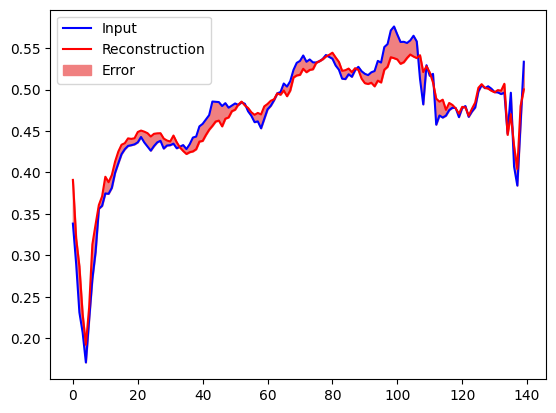

In [15]:
plt.plot(normal_test_data[10], 'b')
plt.plot(test_sample[0], 'r')
plt.fill_between(np.arange(140), normal_test_data[10], test_sample[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()
